In [1]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
from preprocess_ecg_data import load_ecg_data
from scipy.fft import fft, rfft, fftfreq, fftshift, dct
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from scipy.stats import zscore

ECG_LEN = 65536
ECG_WINDOW = 2000
F_SAMPLING = 128

F_MAX = F_SAMPLING/2
N_TOP_FREQ = 5
BPM_2_1HZ = 60

PATH = './ECGData.mat'

In [2]:
# Download heartpy library
# !python -m pip install heartpy

### __Task 0: Data preprocessing__

We are going to preprocess the data by taking the 162 samples of length 65536 and divide it in subsamples of length 2000, "windowing" the data. This will result in a dataframe that will have for each entry:
* A sample of length 200.
* The class of the subsample, wether is ARR (Arrhythmia), CHF (Congestive heart failure) or NSR (Normal sinus rhythm).
* Where sample was the subsample originally obtained.
* which n-th chunk of the original sample is the subsample (1-32).

### __Mapping of labels__: 
* #####    1:ARR (Arrhythmia)
* #####    2:CHF (Congestive heart failure)
* #####    3:NSR (Normal sinus rhythm)

In [3]:
ecg_data = load_ecg_data()

df_ecg_data = pd.DataFrame(ecg_data)
df_ecg_data 

,ecg_data,class,sampled_from,n_chunk
0,"[-0.09785730141312626, -0.15688125766870917, -...",1,1,1
1,"[-0.3484112418649029, -0.02274587725720959, 0....",1,1,2
2,"[-0.4360649375168176, -0.4460280919950408, -0....",1,1,3
3,"[-0.38340009514361517, -0.38383578522187806, -...",1,1,4
4,"[-0.3231552247831461, -0.3163997523002529, -0....",1,1,5
...,...,...,...,...
5179,"[-0.265, -0.265, -0.265, -0.185, -0.085, 0.275...",3,36,28
5180,"[0.065, 0.055, 0.135, 0.225, 0.275, 0.325, 0.3...",3,36,29
5181,"[-0.345, -0.365, -0.355, -0.355, -0.375, -0.34...",3,36,30
5182,"[-0.005, 0.035, -0.045, 0.045, 0.015, -0.035, ...",3,36,31


We are going to visualize one ECG from our dataset. First we are going to create a sample array. Since we know that the sample frequency was 128 hertz, we can create an array of length 2000 with 1/128 intervals.

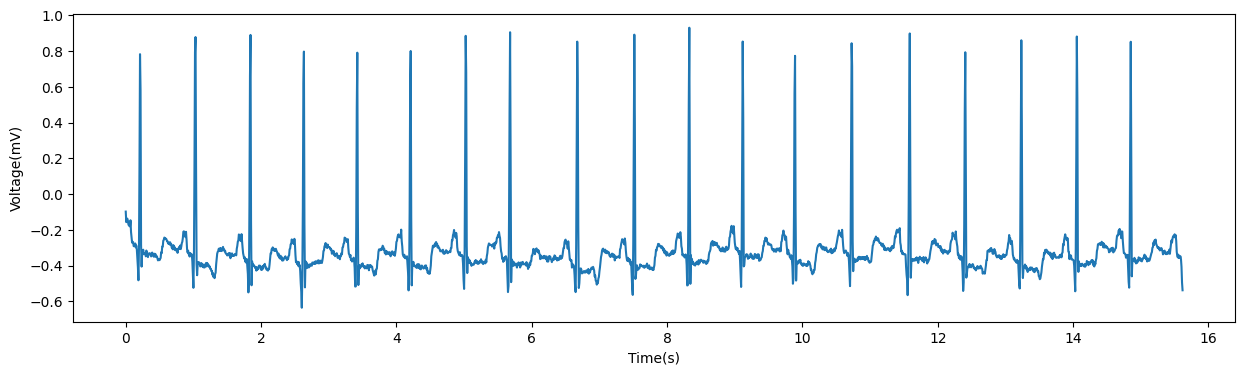

In [4]:
t_values = np.arange(0, ECG_WINDOW * 1/F_SAMPLING, 1/F_SAMPLING)
plt.figure(figsize=(15, 4))
plt.plot(t_values, df_ecg_data['ecg_data'][0])
plt.xlabel("Time(s)")
plt.ylabel("Voltage(mV)")
plt.show()

And there we have our ECG sample plotted. Now onto the tasks.

### __Task 1: Measuring the Heart rate from ECG signals.__

For this task take only ECG samples number 1 and 36 with the label NSR (normal sinus rhythm). For each of the two ECG examples divide the signal into windows of 2000 samples without overlapping. The remaining samples at the end of the file can be discarded.

In [5]:
# Taking the sample 1 and 36 from the NSR
df_ex1 = df_ecg_data[(df_ecg_data['class'] == 3) & ((df_ecg_data['sampled_from'] == 1) | (df_ecg_data['sampled_from'] == 36))]
df_ex1


,ecg_data,class,sampled_from,n_chunk
4032,"[-0.165, -0.155, -0.195, -0.205, -0.185, -0.15...",3,1,1
4033,"[-0.175, -0.175, -0.175, -0.175, -0.215, -0.18...",3,1,2
4034,"[2.235, 2.705, 2.525, 1.205, -0.255, -0.405, -...",3,1,3
4035,"[-0.095, -0.105, -0.115, -0.105, -0.095, -0.08...",3,1,4
4036,"[-0.125, -0.145, -0.165, -0.125, -0.065, -0.10...",3,1,5
...,...,...,...,...
5179,"[-0.265, -0.265, -0.265, -0.185, -0.085, 0.275...",3,36,28
5180,"[0.065, 0.055, 0.135, 0.225, 0.275, 0.325, 0.3...",3,36,29
5181,"[-0.345, -0.365, -0.355, -0.355, -0.375, -0.34...",3,36,30
5182,"[-0.005, 0.035, -0.045, 0.045, 0.015, -0.035, ...",3,36,31


The goal is to obtain the average heart rate for each of the windows considered using for this the analysis of the FFT (Fast Fourier Transform).
We can assume that each ECG sample is provided by two different persons. Therefore, plot an histogram for the average heart rate of the windows for each ECG separately.
Include an analysis of your method and comment your results.

In [6]:
ft = df_ex1['ecg_data'].apply(lambda x: fftshift(fft(x)))
freq = df_ex1['ecg_data'].apply(lambda x: fftshift(fftfreq(x.shape[-1])))

# stack squeezes the dimensions of each entry in the pandas series. If we 
# have an array of N entries, each of one with an array of M values, this 
# operation will squeeze it to a matrix of N*M
np.stack(ft.values).shape

(64, 2000)

In [7]:
# we remain with the positive frequencies
halve_array = lambda x: x[int(len(x)/2):]

# apply the FFT to each of the 2000 windows
ft = np.stack(df_ex1['ecg_data'].apply(lambda x: fftshift(fft(x))).values)
freq = np.stack(df_ex1['ecg_data'].apply(lambda x: fftshift(fftfreq(x.shape[-1]))).values)

freq.shape

(64, 2000)

Now, as we can see, the fft function of python gives us the whole range of frequencies (positives and negatives) normalized between $-1/2 \geq f \geq 1/2$. Since we only want the positive range of the frequencies, we are going to halve both the values of the fourier transform (`ft`) and the frequency index (`freq`) arrays.

In [8]:
# we only get the positive frequencies
ft_positive = np.apply_along_axis(halve_array, axis=1, arr=ft)
freq_positive = np.apply_along_axis(halve_array, axis=1, arr=freq)

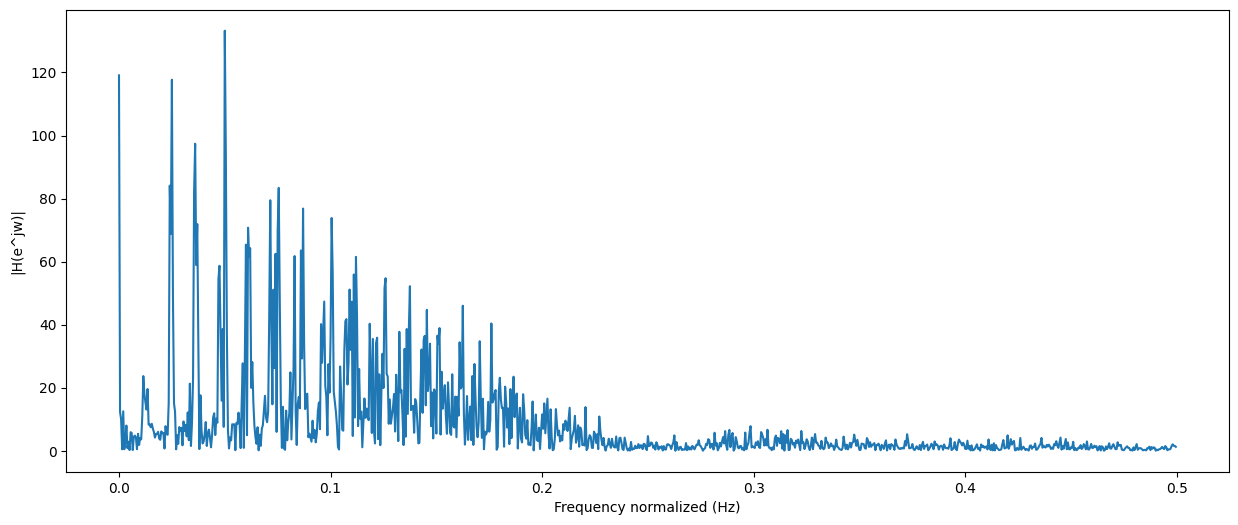

In [9]:
sample=1

ft_sample = abs(np.array(ft_positive)[sample].real)
freq = np.array(freq_positive)[sample]


plt.figure(figsize=(15, 6))
plt.plot(freq, ft_sample)
plt.xlabel('Frequency normalized (Hz)')
plt.ylabel('|H(e^jw)|')
plt.show()

Now, we have only the positive range of values of our fourier transform.

We have another issue with this dataset, and it is the fact that, from the fourier transform, we only get the normalized frequencies, but our dataset was collected by sampling with a frequency of 128 Hz.

Following the Nyquist sampling theorem, a optimum frequency sample should follow the formula:

$$
f_s \geq 2 * f_{max}
$$

If we suppose that the frequency of sampling for this dataset follows this theorem, and $f_s=128$, then, the $f_{max}$ should be equal to 64. This means that, the higher frequency of the ECG, would suposedly be 64 Hz, and from that point, we could infer the rest of the frequencies from the normalized scale to the original one. Once we have done this, we convert the frequencies to BPM (by multiplying by 60, since 1hz -> 60BPM) and we would obtain our frequencies in the BPM domain.

In [10]:

HEIGHT=max(ft_sample)*0.30
print(HEIGHT)
peaks, _ = find_peaks(ft_sample, height=HEIGHT, distance=15)
print(peaks[0:5])

if peaks[0]>=45:                # Si la distancia entre picos es muy grande es que el umbral esta por encima de un pico por lo que se baja el umbral
    HEIGHT=max(ft_sample)*0.10
    print(HEIGHT)
    peaks, _ = find_peaks(ft_sample, height=HEIGHT, distance=20)
    print(peaks[0:5])

if peaks[0]<=20:                # Si la distancia entre picos es muy pequeña es que se estan detectando dos picos seguidos por lo que se aumenta la distancia entre picos
    peaks, _ = find_peaks(ft_sample, height=HEIGHT, distance=40)
    print(peaks[0:5])

frec=64/1000   # regla de tres si 0.5Hz normalizados => 64Hz (T Nyquist) => 1000 muestras
                #                                       BPS              => peaks[0] muestras
print(frec)

BPM=peaks[0]*frec*60    # peaks[0]*frec (BPS) x 60 = BPM
print(BPM)

39.972527500541936
[ 50  72 100 122 151]
13.32417583351398
[ 23  50  72 100 122]
0.064
88.32


In [11]:
# we order the frequencies depending on the highest value the fourier transform has
top_frequencies_idx = np.argsort(ft_sample)[::-1]
top_frequencies_idx[:N_TOP_FREQ]

array([100,   0,  50,  72, 101])

In [12]:
# we get the indices of the 
top_frequencies = freq[top_frequencies_idx[:N_TOP_FREQ]]
top_frequencies

array([0.05  , 0.    , 0.025 , 0.036 , 0.0505])

In [13]:
frequencies_converted = (top_frequencies/freq[-1]*F_MAX)*BPM_2_1HZ
frequencies_converted

array([384.38438438,   0.        , 192.19219219, 276.75675676,
       388.22822823])

In [14]:
bpm=np.zeros(len(ft_positive))
peaks0=np.zeros(5,)
peaks1=np.zeros(5,)


for i in range(len(ft_positive)):
    ft_sample = abs(np.array(ft_positive)[i].real)
    freq = np.array(freq_positive)[i]
    
    HEIGHT=max(ft_sample)*0.30
    #print(HEIGHT)
    peaks, _ = find_peaks(ft_sample, height=HEIGHT, distance=15)
    peaks0=peaks[0:5]
    #print(peaks[0:5])
    if peaks[0]>=45:
        HEIGHT=max(ft_sample)*0.10
        #print(HEIGHT)
        peaks, _ = find_peaks(ft_sample, height=HEIGHT, distance=20)
        #print(peaks[0:5])
        peaks0=peaks[0:5]
        peaks1=peaks[0:5]

    if peaks[0]<=20:
        peaks, _ = find_peaks(ft_sample, height=HEIGHT, distance=40)
        #print(peaks[0:5])
        peaks1=peaks[0:5]

    frec=64/1000
    

    #print(frec)
    if (peaks1[0]<=20):
        BPM=peaks0[0]*frec*60
          
    else:
        BPM=peaks1[0]*frec*60

    bpm[i]=BPM

print(bpm) # 64 bpm = 32 bpm of the user 1 and 32 bpm of the user 36

[ 96.    88.32  96.    96.    96.    96.    96.    96.    96.    96.
  96.    96.    96.    92.16  92.16  92.16  92.16  92.16  92.16 111.36
 111.36 107.52 107.52   7.68 115.2  115.2   99.84 107.52 111.36 111.36
 115.2  126.72  65.28  69.12  11.52  65.28  65.28  11.52   7.68   7.68
   7.68   7.68  26.88  57.6   57.6   61.44  65.28  15.36  80.64  80.64
  69.12  65.28  61.44  61.44 126.72  61.44  69.12 126.72 138.24  46.08
   7.68  19.2  149.76  49.92]


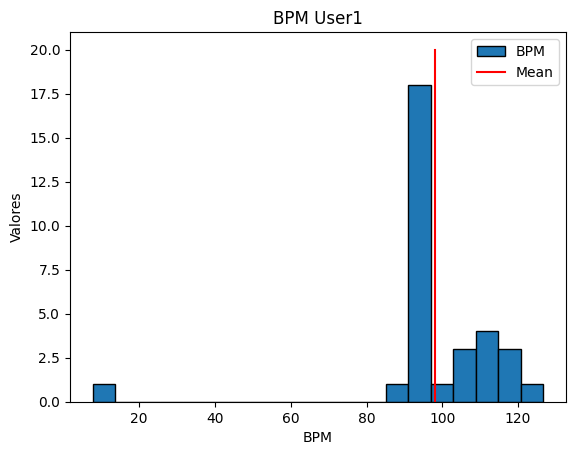

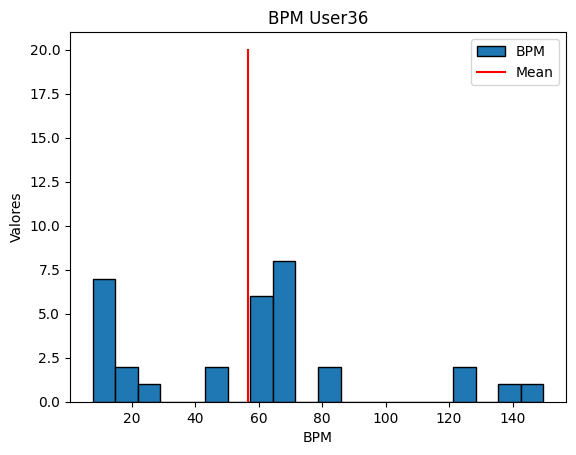

In [15]:
# Histogram
user1=bpm[0:32]
user36=bpm[32:64]

# mean
mean1=np.mean(user1)
mean36=np.mean(user36)

# Histogram user1
fig, ax = plt.subplots()
ax.hist(user1, bins=20, edgecolor = "black", label="BPM")
ax.plot([mean1,mean1], [0,20], color = "red", label="Mean")
ax.legend()
ax.set_title("BPM User1")
ax.set_xlabel('BPM')
ax.set_ylabel('Valores')
plt.show()

# Histogram user 36
fig, ax = plt.subplots()
ax.hist(user36, bins=20, edgecolor = "black", label="BPM")
ax.plot([mean36,mean36], [0,20], color = "red", label="Mean")
ax.legend()
ax.set_title('BPM User36')
ax.set_xlabel('BPM')
ax.set_ylabel('Valores')
plt.show()



### __Task 3: Classification of ECG signals.__

* Let’s consider a balanced problem with the same number of examples per class. We will consider the first 30 ECG examples per class in this task.
* Divide the data into training and test sets considering the first 21 examples of each class for training and the remaining 9 examples per testing.
* Then remember that each ECG signal will be further divided into time windows with length 2000 samples without overlap. Each time window will be considered as a new example in the database.
* The objective of this task is to develop a system to automatically classify between the three types of ECG signals in the database. The measure to maximize is the accuracy.

In [16]:
ecg_data = load_ecg_data()
df_ecg_data = pd.DataFrame(ecg_data)

#### Feature extraction

We are going to extract some features from our dataset. In our case, we opted for using the FFT, the DCT over the FFT and some local and global features such as:
* Local Features: first derivatives and second derivatives
* Global Features: Avg distance between peaks or number of heartbeats

__Local Features extraction__: First derivatives and second derivatives

In [17]:
df_ecg_data['deriv1'] = df_ecg_data['ecg_data'].apply(lambda x: np.gradient(np.array(x)))
df_ecg_data['deriv2'] = df_ecg_data['deriv1'].apply(lambda x: np.gradient(np.array(x)))

__Global Features extraction__: Avg distance between peaks and number of heartbeats

In [18]:
from sklearn.preprocessing import StandardScaler

stacked_data = np.stack(df_ecg_data['ecg_data'])

scaler = StandardScaler()
scaler.fit(stacked_data)
stacked_data_t = scaler.transform(stacked_data)

In [19]:
from feature_extraction import avg_d_between_peaks, std_d_between_peaks, compute_bpm, compute_std_bpm, compute_max_bpm, compute_min_bpm

avg_d = np.apply_along_axis(avg_d_between_peaks, 1, stacked_data_t)
std_d = np.apply_along_axis(std_d_between_peaks, 1, stacked_data_t)
avg_bpm = np.apply_along_axis(compute_bpm, 1, stacked_data_t)
std_bpm = np.apply_along_axis(compute_std_bpm, 1, stacked_data_t)
max_bpm = np.apply_along_axis(compute_max_bpm, 1, stacked_data_t)
min_bpm = np.apply_along_axis(compute_min_bpm, 1, stacked_data_t)

df_ecg_data['avg_d_peaks'] = avg_d
df_ecg_data['std_d_peaks'] = std_d
df_ecg_data['avg_bpm'] = avg_bpm
df_ecg_data['std_bpm'] = std_bpm
df_ecg_data['max_bpm'] = max_bpm
df_ecg_data['min_bpm'] = min_bpm

In [20]:
df_ecg_data[df_ecg_data['avg_bpm'].isna()]

,ecg_data,class,sampled_from,n_chunk,deriv1,deriv2,avg_d_peaks,std_d_peaks,avg_bpm,std_bpm,max_bpm,min_bpm
284,"[-1.0662847235264512, -1.0309784560564395, -1....",1,9,29,"[0.035306267470011754, 0.014066313509724204, -...","[-0.02123995396028755, -0.021985976017364184, ...",NaN,NaN,NaN,NaN,NaN,NaN
615,"[-0.35306386911786447, -0.3534806814825913, -0...",1,20,8,"[-0.00041681236472684846, 0.009831688078735107...","[0.010248500443461955, -0.01052156999218841, -...",NaN,NaN,NaN,NaN,NaN,NaN
689,"[-0.06535958358140768, -0.020601499800116285, ...",1,22,18,"[0.0447580837812914, 0.02524105334887101, 0.01...","[-0.019517030432420385, -0.01389549396888979, ...",NaN,NaN,NaN,NaN,NaN,NaN
698,"[0.015763687778235974, 0.004570186342316302, -...",1,22,27,"[-0.011193501435919672, -0.026332662590596398,...","[-0.015139161154676726, -0.007598680044177543,...",NaN,NaN,NaN,NaN,NaN,NaN
700,"[-0.20523783375186522, -0.21692920708203706, -...",1,22,29,"[-0.01169137333017184, -0.0012903085596754627,...","[0.010401064770496377, 0.003754522633824371, 0...",NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
4003,"[-0.8385836676884582, -0.8618173636519676, -0....",2,30,4,"[-0.023233695963509438, 0.006395170470559042, ...","[0.02962886643406848, 0.010756855468702364, -0...",NaN,NaN,NaN,NaN,NaN,NaN
4004,"[-0.2195897445696414, 0.6412007206669135, 1.07...",2,30,5,"[0.8607904652365549, 0.6483540194648197, -0.14...","[-0.21243644577173515, -0.5045516737018101, -0...",NaN,NaN,NaN,NaN,NaN,NaN
4493,"[-0.275, -0.265, -0.235, -0.225, -0.225, -0.22...",3,15,14,"[0.010000000000000009, 0.020000000000000018, 0...","[0.010000000000000009, 0.0049999999999999975, ...",NaN,NaN,NaN,NaN,NaN,NaN
4494,"[-0.345, -0.355, -0.355, -0.345, -0.345, -0.33...",3,15,15,"[-0.010000000000000009, -0.0050000000000000044...","[0.0050000000000000044, 0.007500000000000007, ...",NaN,NaN,NaN,NaN,NaN,NaN


As we commented in the code above, there is going to appear some nan's caused by the topology of some samples, where there are one or none peaks detected, and we cannot compute the RR distances and the BPMs of each sample. In order to fill this nan's, we will use the mean for each class, to not affect the distribution.

In [21]:
bpm_means = df_ecg_data.groupby('class')['avg_bpm'].mean()
bpm_std_means = df_ecg_data.groupby('class')['std_bpm'].mean()
bpm_max_means = df_ecg_data.groupby('class')['max_bpm'].mean()
bpm_min_means = df_ecg_data.groupby('class')['min_bpm'].mean()
avd_d_means = df_ecg_data.groupby('class')['avg_d_peaks'].mean()
std_d_means = df_ecg_data.groupby('class')['std_d_peaks'].mean()

df_ecg_data['avg_bpm'] = df_ecg_data.apply(lambda row: bpm_means[row['class']] if pd.isna(row['avg_bpm']) else row['avg_bpm'], axis=1)
df_ecg_data['std_bpm'] = df_ecg_data.apply(lambda row: bpm_std_means[row['class']] if pd.isna(row['std_bpm']) else row['std_bpm'], axis=1)
df_ecg_data['max_bpm'] = df_ecg_data.apply(lambda row: bpm_max_means[row['class']] if pd.isna(row['max_bpm']) else row['max_bpm'], axis=1)
df_ecg_data['min_bpm'] = df_ecg_data.apply(lambda row: bpm_min_means[row['class']] if pd.isna(row['min_bpm']) else row['min_bpm'], axis=1)
df_ecg_data['avg_d_peaks'] = df_ecg_data.apply(lambda row: avd_d_means[row['class']] if pd.isna(row['avg_d_peaks']) else row['avg_d_peaks'], axis=1)
df_ecg_data['std_d_peaks'] = df_ecg_data.apply(lambda row: std_d_means[row['class']] if pd.isna(row['std_d_peaks']) else row['std_d_peaks'], axis=1)
df_ecg_data

,ecg_data,class,sampled_from,n_chunk,deriv1,deriv2,avg_d_peaks,std_d_peaks,avg_bpm,std_bpm,max_bpm,min_bpm
0,"[-0.09785730141312626, -0.15688125766870917, -...",1,1,1,"[-0.059023956255582904, -0.019979427765969324,...","[0.03904452848961358, 0.0344381041616524, 0.00...",103.944444,2.717683,73.885623,1.922435,77.575758,69.818182
1,"[-0.3484112418649029, -0.02274587725720959, 0....",1,1,2,"[0.3256653646076933, 0.4678561896988175, 0.493...","[0.14219082509112418, 0.08400456235294218, -0....",103.631579,3.029861,74.108685,2.152329,77.575758,69.818182
2,"[-0.4360649375168176, -0.4460280919950408, -0....",1,1,3,"[-0.009963154478223213, -0.006462586527347575,...","[0.003500567950875638, 0.004696099230614967, 0...",103.666667,2.494438,74.083601,1.779547,76.800000,71.111111
3,"[-0.38340009514361517, -0.38383578522187806, -...",1,1,4,"[-0.00043569007826288475, 0.011976453998027381...","[0.012412144076290266, 0.005613563976551134, -...",103.944444,3.170563,73.885623,2.232525,76.800000,69.818182
4,"[-0.3231552247831461, -0.3163997523002529, -0....",1,1,5,"[0.00675547248289321, 0.0002321741644971398, -...","[-0.00652329831839607, -0.003785852940457468, ...",102.861111,2.623640,74.663786,1.895985,78.367347,71.111111
...,...,...,...,...,...,...,...,...,...,...,...,...
5179,"[-0.265, -0.265, -0.265, -0.185, -0.085, 0.275...",3,36,28,"[0.0, 0.0, 0.04000000000000001, 0.09, 0.23, 0....","[0.0, 0.020000000000000004, 0.045, 0.095, 0.11...",124.218750,7.472802,61.826415,3.692136,70.458716,54.857143
5180,"[0.065, 0.055, 0.135, 0.225, 0.275, 0.325, 0.3...",3,36,29,"[-0.010000000000000002, 0.035, 0.085, 0.07, 0....","[0.045000000000000005, 0.0475, 0.0175, -0.0175...",98.275000,4.526243,78.148054,3.465110,81.702128,71.111111
5181,"[-0.345, -0.365, -0.355, -0.355, -0.375, -0.34...",3,36,30,"[-0.020000000000000018, -0.0050000000000000044...","[0.015000000000000013, 0.012500000000000011, -...",102.578947,4.464076,74.869164,3.181183,80.842105,67.368421
5182,"[-0.005, 0.035, -0.045, 0.045, 0.015, -0.035, ...",3,36,31,"[0.04, -0.02, 0.0049999999999999975, 0.03, -0....","[-0.06, -0.0175, 0.025, -0.0225, -0.0024999999...",100.263158,4.375074,76.598425,3.319600,82.580645,70.458716


Now that we have filled all the data, we can continue with the analysis.

__FFT and DCT__

In [32]:
df_ecg_data['fft'] = df_ecg_data['ecg_data'].apply(lambda x: fftshift(fft(x).real))
df_ecg_data['dct'] = df_ecg_data['fft'].apply(lambda x: dct(rfft(20*np.log(np.abs(x)), n=2, norm='ortho')))
df_ecg_data['dct_orig'] = df_ecg_data['fft'].apply(lambda x: dct(x, n=2, norm='ortho'))
df_ecg_data['dct_1coef'] = df_ecg_data['fft'].apply(lambda x: dct(x, n=2, norm='ortho')[0])

#### Data Splitting for our classification 

In [45]:
range_class = range(1,4)
range_samples_per_class = range(1,31)
range_train_samples = range(1,22)
range_test_samples = range(22,31)

df_train = df_ecg_data[(df_ecg_data['sampled_from'].isin(range_train_samples))]
df_test = df_ecg_data[(df_ecg_data['sampled_from'].isin(range_test_samples))]

# dropping useless columns for classification
df_train = df_train.drop(columns=['sampled_from', 'n_chunk'])
df_test = df_test.drop(columns=['sampled_from', 'n_chunk'])

df_test.describe()

,class,avg_d_peaks,std_d_peaks,avg_bpm,std_bpm,max_bpm,min_bpm,dct_1coef
count,864.00000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000
mean,2.00000,93.029643,16.595479,95.746895,13.493116,122.655867,79.347043,-0.103839
std,0.81697,76.706554,39.424974,26.639971,15.083471,40.522641,25.380041,1.023397
min,1.00000,41.000000,0.000000,5.880551,0.000000,5.880551,5.880551,-8.662996
25%,1.00000,70.653159,2.320923,80.313873,2.295318,93.658537,66.638681,-0.493218
50%,2.00000,82.288538,5.088333,93.753839,5.391306,111.304348,81.702128,-0.016543
75%,3.00000,96.740132,16.284518,108.700065,20.185649,147.692308,96.000000,0.410492
max,3.00000,1306.000000,388.673242,187.317073,89.155080,192.000000,187.317073,3.853186


#### __Classification__

Now with our feature extraction completed, we are going to classify our samples. In order to do this we are going to use to approaches:

* __SVM__: We are going to use the SVC Support Vector Classifier from the `sklearn` library.
* __Random Forest__: We are going to use the a boosting algorithm called Random Forest from the `sklearn` library.
* __LSTM__: Since the data that we are using may have temporal dependencies, we think that a LSTM mixed with some features that we have extracted may work quite well classifying the samples. We will use `keras` for this approach.

In [46]:
X_train, y_train =  df_train.loc[:, df_train.columns!='class'], df_train['class']
X_test, y_test =  df_test.loc[:, df_test.columns!='class'], df_test['class']

In [47]:
X_train_singles_feat =  X_train.loc[:, X_train.columns.difference(['deriv1', 'deriv2', 'fft', 'dct', 'ecg_data', 'dct_orig'])]
X_test_singles_feat =  X_test.loc[:, X_test.columns.difference(['deriv1', 'deriv2', 'fft', 'dct', 'ecg_data', 'dct_orig'])]

X_train_ecg_data = np.stack(X_train['ecg_data'].values)
X_test_ecg_data = np.stack(X_test['ecg_data'].values)

X_train_dct = np.stack(X_train['dct_orig'].values)
X_test_dct= np.stack(X_test['dct_orig'].values)

#### __SVM__: Classic ML approach

In [48]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Constantes
C=15
KERNEL='rbf'

clf = make_pipeline(StandardScaler(), SVC(C=C, kernel=KERNEL, gamma='auto', probability=True))
clf.fit(X_train_dct,y_train)

y_train_pred = clf.predict(X_train_dct)
train_score = accuracy_score(y_train, y_train_pred)

y_test_pred = clf.predict(X_test_dct)
test_score = accuracy_score(y_test, y_test_pred)

print(f"Training score: {train_score} | Test score: {test_score}")

Training score: 0.5932539682539683 | Test score: 0.5219907407407407


In [49]:
clf = make_pipeline(StandardScaler(), SVC(C=C, kernel=KERNEL, gamma='auto', probability=True))
clf.fit(X_train_ecg_data,y_train)

y_train_pred = clf.predict(X_train_ecg_data)
train_score = accuracy_score(y_train, y_train_pred)

y_test_pred = clf.predict(X_test_ecg_data)
test_score = accuracy_score(y_test, y_test_pred)

print(f"Training score: {train_score} | Test score: {test_score}")

Training score: 0.9910714285714286 | Test score: 0.7337962962962963


#### __Random Forest__: Classic ML approach

In [55]:
from sklearn.ensemble import RandomForestClassifier

# Constantes
C=15
KERNEL='rbf'

clf = make_pipeline(StandardScaler(), RandomForestClassifier())
clf.fit(X_train_singles_feat,y_train)

y_train_pred = clf.predict(X_train_singles_feat)
train_score = accuracy_score(y_train, y_train_pred)

y_test_pred = clf.predict(X_test_singles_feat)
test_score = accuracy_score(y_test, y_test_pred)

print(f"Training score: {train_score} | Test score: {test_score}")

Training score: 1.0 | Test score: 0.5335648148148148


#### __LSTM__: Capturing the temporal dependencies, the Deep Learning approach

In [51]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, LSTM, Normalization,Dropout

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

# It is possible to change the variables: units of layers, function loss, optimizer, epochs, and batch size
EPOCHS=10
BATCH_SIZE=64

1 Physical GPUs, 1 Logical GPUs


In [52]:
# Design the model
# Input: shape of the X_train_ecg_data 
ecg_input = keras.layers.Input(shape=(X_train_ecg_data.shape[1], 1), batch_size=BATCH_SIZE)
ecg_input_norm = Normalization(axis=1)(ecg_input)
x = LSTM(units=32, activation="tanh", return_sequences=False)(ecg_input_norm)
x = Dropout(0.2)(x)
x = Dense(units=32, activation="relu")(x)
output = Dense(3, activation="softmax")(x) # Output: three possibles targets (1,2,3)

model = keras.Model(ecg_input, output)

model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(64, 2000, 1)]           0         
                                                                 
 normalization_1 (Normaliza  (64, 2000, 1)             4001      
 tion)                                                           
                                                                 
 lstm_1 (LSTM)               (64, 32)                  4352      
                                                                 
 dropout_1 (Dropout)         (64, 32)                  0         
                                                                 
 dense_2 (Dense)             (64, 32)                  1056      
                                                                 
 dense_3 (Dense)             (64, 3)                   99        
                                                           

In [53]:
X_train_ecg_data = np.stack(X_train['ecg_data'].values)
X_test_ecg_data = np.stack(X_test['ecg_data'].values)

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Training the model
history = model.fit(X_train_ecg_data, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

Epoch 1/10
32/32 [==============================] - 2s 35ms/step - loss: nan - accuracy: 0.0074
Epoch 2/10
32/32 [==============================] - 1s 35ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 3/10
32/32 [==============================] - 1s 35ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 4/10
32/32 [==============================] - 1s 35ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 5/10
32/32 [==============================] - 1s 35ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 6/10
32/32 [==============================] - 1s 35ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 7/10
32/32 [==============================] - 1s 35ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 8/10
32/32 [==============================] - 1s 35ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 9/10
32/32 [==============================] - 1s 35ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 10/10
32/32 [==============================] - 1s 35ms/step - loss: nan - accuracy: 0.0000e+00


In [54]:
# Evaluate the model with loss and accuracy
loss, accuracy = model.evaluate(X_test_ecg_data, y_test, verbose=0)

print(f"Test loss: {loss} | Test accuracy: {accuracy}")

Test loss: nan | Test accuracy: 0.0
